Welcome to the first lab module of the RL course!

## Install Dependencies
This module is used for colab notebook on google, skip if you are using the provided container or your own environment
Based on stable baseline zoo notebook: https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/rl-baselines-zoo.ipynb 

To start with colab, you need to click the "connect" button on the top right corner to allocate a VM for the notebook, you would want to change to GPU if it shows CPU. 

Then you can run the following cells to install the dependencies. It should take 2~3 minutes to finish. Run the next cell to check if GPU is enabled.

In [1]:
!apt-get update && apt-get install swig cmake ffmpeg freeglut3-dev xvfb
!git clone https://github.com/DLR-RM/rl-baselines3-zoo
%cd /content/rl-baselines3-zoo/
%pip install -r requirements.txt
%cd /content/
!git clone https://github.com/yusenz/gym-maze.git
%cd /content/gym-maze
%pip install -e .
%cd /content/
%pip install opencv-python-headless

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease    
Fetched 257 kB in 1s (284 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
swig is already the newest version (4.0.2-1ubuntu1).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.11).
0 upgraded, 0 newly installed, 0 to remove and 61 not upgraded.
Cloning into 'rl-baselines3-zoo'...
remote: Enumerating objects: 5511, done.
remo

/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [1]:
# sanity testing to see if you have gpu setup correctly
# Should display True, 0, and the name of your GPU or some Tesla device on Colab
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
0
NVIDIA GeForce RTX 4070 Ti


## Section 1: The environment
As we discussed in the beginning of the course, as well as what you have seen in the first assignment, before we rush to fancy RL algorithms, it is important to understand the problem we are trying to solve. In common baseline environments, these can be already defined for us. However, for practical application, we need to figure out what are the observable states, what are the actions we can take, and design a reward function that will guide the agent to the desired behavior. 
The most commonly used environment interface in RL research is the OpenAI Gym or the following Gymnasium, and almost all RL implementations can utilize this interface. For practical applications, you may need to write gym wrapper for your own environment, or implement a different control flow due to gym limitations. For now, we will stick to the gym interface. For those who are familiar with older gym versions, we are using gym 0.26.2 here, with `env.step()` returning `state, reward, terminated, truncated, info` instead of `state, reward, done, info`. Also, A LOT of available environments on the internet are using older gym versions, so be careful when you are using them, or fork and manually update the environment. 
In this lab module, we will be using a 2d maze environment slightly modified from [the original repo](https://github.com/MattChanTK/gym-maze) updated for newer gym version and ipython notebook compatibility. The next cell is the description of the environment adapted from the README of the original repo.

### Environment Details
A simple 2D maze environment where an agent (blue dot) finds its way from the top left corner (blue square) to the goal at the bottom right corner (red square). 
The objective is to find the shortest path from the start to the goal.

<kbd>![Simple 2D maze environment](http://i.giphy.com/Ar3aKxkAAh3y0.gif)</kbd>

#### Action space
The agent may only choose to go up, down, right, or left ("N", "S", "E", "W"; or alternatively: 0, 1, 2, 3). If the way is blocked, it will remain at the same the location. 

#### Observation space
The observation space is the (x, y) coordinate of the agent. The top left cell is `[0. 0.]`.

#### Reward
A reward of 1 is given when the agent reaches the goal. For every step in the maze, the agent recieves a reward of -0.1/(number of cells). This penalty can be adjusted by the `penalty=0.1` parameter, and the normalization is controlled by `penalty_normalize='size'`. I have implemented a few other normalizations: 'none', 'sqrt_size', 'log_size'. You can use `env = gym.make('maze-sample-10x10-v0',penalty=penalty,penalty_normalize=penalty_normalize)` to change the penalty and normalization.

#### End condition
The maze is reset when the agent reaches the goal (terminated), or maximum time step (10,000 for 10x10 maze) is reached (truncated). 

### Questions
Why do you think the reward needs a penalty for each step? What would happen if we don't have this penalty? What would happen if we normalize this penalty differently?
<details>
<summary>Click to reveal</summary>
 - Thinking might not be the easiest way to solve this, you can try this out with your own experimentation.
</details>

In the non backward compatible gym update, the `done` flag is replaced by `terminated` and `truncated`. The `terminated` flag is set to `True` when the agent reaches the goal, and `truncated` is set to `True` when the maximum time step is reached. Why do you think we need to differentiate between these two flags? How should the agent behave when `truncated` is `True`?
<details>
<summary>Click to reveal</summary>
 - When the agent reaches the goal, the game is finished, and the agent does not have any meaningful action or a q value to update. However, when the maximum time step is reached, the agent can still move in the future, but we cut it off for the current episode. This means that the truncated state can still have a value function. This can be more relevant with more aggressive truncation.
</details>

## Section 2: The agent
The agent is what we learn in RL. The most important aspect of the agent is that, when called by the main loop given a state, it should have the `select_action` method that returns an action - in the most basic random agent, this method will just give a random action irrespective of the state. 
The base class of the agent is the `BaseAgent` class, which maintains the cumulative reward and the number of steps taken for the current episode if `super().init()`, `super().update_step()` and `super().update_episode()` are called in the actual implementation. Run the next cell to define the `BaseAgent` class.

In [1]:
class BaseAgent:
    def __init__(self, env, verbose=1):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.verbose = verbose
        self.cumulative_reward = 0
        self.num_steps = 0
    def select_action(self, state):
        raise NotImplementedError
    def update_step(self, reward: float):
        self.cumulative_reward += reward
        self.num_steps += 1
    def update_episode(self):
        self.reset_episode()
    def update_rollout(self):
        if self.verbose > 0:
            print('update_rollout in base class is called, nothing is changed')
    def update_replay(self):
        if self.verbose > 0:
            print('update_replay in base class is called, nothing is changed')
    def reset_episode(self):
        self.cumulative_reward = 0
        self.num_steps = 0


We also provide a random agent for free! The random agent will randomly choose an action from the action space. Run the next cell to define the `random_agent` class.

In [2]:
class RandomAgent(BaseAgent):
    def __init__(self, env, verbose=1):
        self.cumulative_reward = 0
        super().__init__(env, verbose)
    def select_action(self, state):
        action = self.action_space.sample()
        if self.verbose > 1:
            print('Random agent selected action: ', action)
        return action
    def update_step(self, old_state, action, reward, new_state):
        super().update_step(reward)
    def update_episode(self, terminated, truncated):
        if self.verbose > 0:
            if terminated:
                print('Episode terminated')
            if truncated:
                print('Episode truncated')
        super().update_episode()
    def update_rollout(self):
        pass
    def update_replay(self):
        pass

## Section 3: The training loop
Now that we have the environment and the agent, we can construct the main loop that let the agent interact with the environment, and let the agent learn from the interaction - although in the case of the random agent, it will not learn anything.
Run the next cell to define the main loop that let the random agent interact with the environment for a maximum of 200,000 steps with a 10x10 maze for no more than 100 episodes. With default settings, the random agent will usually time out but occasionally reach the goal. You can try the more aggressive truncation as shown in the commented out code so that you can plot the reward with more episodes - but the agent will likely not reach the goal at all in this case. To demonstrate this effect of cut off, the reward is plotted both against the number of steps and the number of episodes. For random agent, it does not learn and this plot will look like noise. However, for an agent that learns, the reward should increase over time - or you messed up somewhere.
This block of code is also used for all the following agents by changing the agent class.

In [15]:
import gym
import gym_maze
import numpy as np
import sys
from matplotlib import pyplot as plt
import IPython.display as display
import cv2


def main_loop(agent, args):
    ## experiment parameters
    # Training terminates on either reaching NUM_EPISODES or MAX_STEPS_TOTAL
    NUM_EPISODES = args['NUM_EPISODES']
    MAX_STEPS_TOTAL = args['MAX_STEPS_TOTAL']
    RENDER_MAZE = args['RENDER_MAZE']
    RENDER_EVERY = args['RENDER_EVERY']  # render every RENDER_EVERY episode because rendering can be slow
    verbose = args['verbose']
    display_handle = args['display_handle']

    ## environment
    env = args['env']
    obv = env.reset()
    # if RENDER_MAZE:
    #     env.render()

    ## additional parameter initialization
    total_steps = 0
    cumulative_reward_array = []
    num_steps_array = []

    ## main loop
    for episode in range(NUM_EPISODES):
        obv = env.reset()
        # truncation is handled by the gym environment
        for step in range(MAX_STEPS_TOTAL):
            total_steps += 1
            old_obv = obv
            action = agent.select_action(old_obv)
            new_obv, reward, terminated, truncated, info = env.step(action)
            if RENDER_MAZE and episode % RENDER_EVERY == 0:
                frame = env.render(mode="rgb_array")
                # ipython display DOES NOT support rgb_array which should literally be bitmap
                # turns out they dont support bitmap either
                # bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                bgr_frame = frame[:, :, ::-1]
                _, frame_png = cv2.imencode('.png', bgr_frame)
                frame_bytes = frame_png.tobytes()
                display_handle.update(display.Image(data=frame_bytes))


            agent.update_step(old_obv, action, reward, new_obv)
            if terminated or truncated:
                print(f'Episode {episode} finished after {int(agent.num_steps)} steps with total reward {agent.cumulative_reward}')
                cumulative_reward_array.append(agent.cumulative_reward)
                num_steps_array.append(agent.num_steps)
                agent.update_episode(terminated, truncated)
                break
            if total_steps >= MAX_STEPS_TOTAL:
                break
        if total_steps >= MAX_STEPS_TOTAL:
            break
        
    plt.plot(cumulative_reward_array)
    plt.title(f'Cumulative reward per episode for agent {agent.__class__.__name__}')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative reward')
    plt.show()

    # plot against number of steps spent
    num_steps_cumulative = np.cumsum(num_steps_array)
    plt.plot(num_steps_cumulative, cumulative_reward_array)
    plt.title(f'Cumulative reward against number of steps for agent {agent.__class__.__name__}')
    plt.xlabel('Number of steps')
    plt.ylabel('Cumulative reward')
    plt.show()



In [11]:
print(cv2.useOptimized()) 

True


Then, run the next cell to see the random agent in action.

error: XDG_RUNTIME_DIR not set in the environment.
libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)



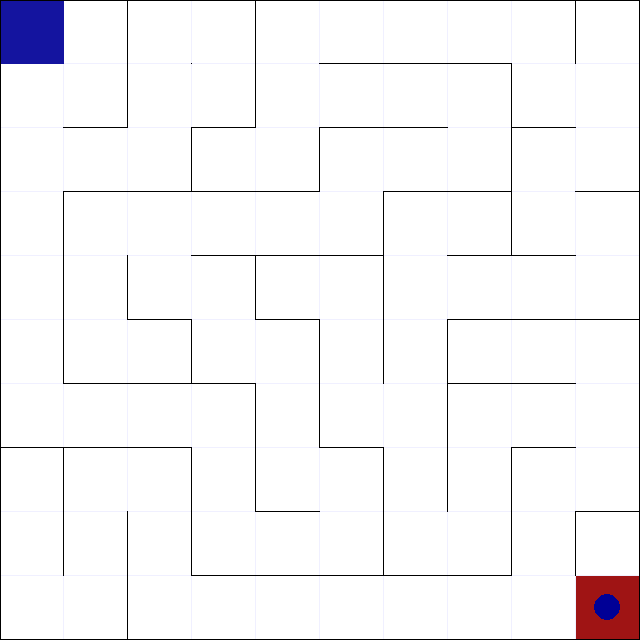

Episode 0 finished after 3911 steps with total reward -2.9099999999996804
Episode terminated


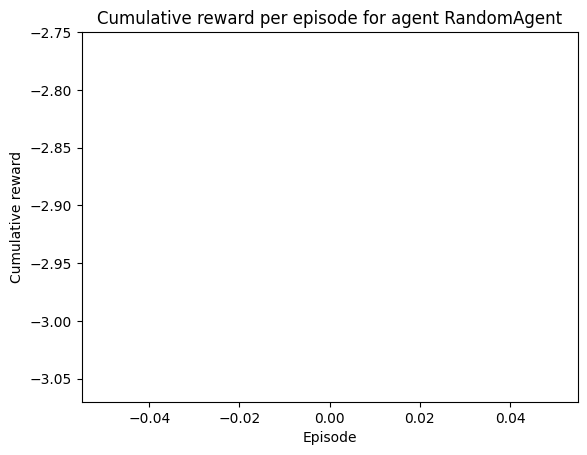

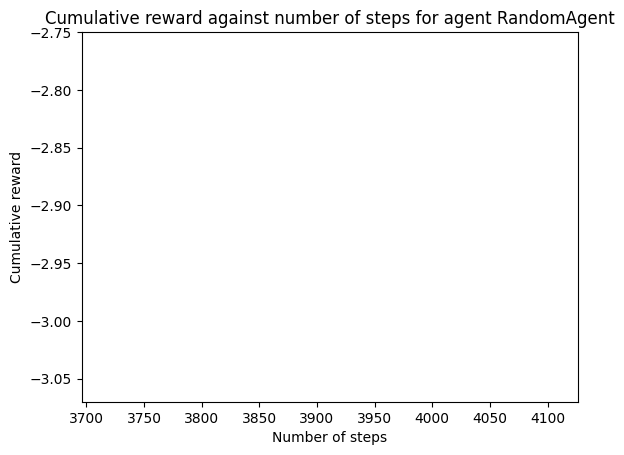

In [19]:
env = gym.make('maze-sample-10x10-v0')
# Default max_episode_steps is 10000 for 10x10 maze
# Can be changed with the following line - Note: you HAVE TO comment one out or pygame will throw error with rendering
# env = gym.make("maze-sample-10x10-v0", max_episode_steps=2000)
args = {
    'env': env,
    'NUM_EPISODES': 1,
    'MAX_STEPS_TOTAL': 200000,
    'RENDER_MAZE': True,
    'RENDER_EVERY': 5,
    'verbose': 1,
    'display_handle': display.display(None, display_id=True)
}
agent = RandomAgent(env)
main_loop(agent, args)

## Section 4: Monte Carlo
Monte Carlo methods learn from the full episode. This means that the agent should only update the value function after the episode is finished in `update_episode`. But you do want to store the visited states and actions at each step in `update_step`. 
Fill in the blanks into the next block to define the Monte Carlo agent, then run the following block to see the Monte Carlo agent in action.

In [ ]:
class MonteCarloAgent(BaseAgent):
    def __init__(self, env, verbose=1):
        super().__init__(env, verbose)
    def select_action(self, state):
        raise NotImplementedError
    def update_step(self, old_state, action, reward, new_state):
        super().update_step(reward)
    def update_episode(self, terminated, truncated):
        if self.verbose > 0:
            if terminated:
                print('Episode terminated')
            if truncated:
                print('Episode truncated')
        super().update_episode()
    def reset_episode(self):
        super().reset_episode()

In [ ]:
env = gym.make('maze-sample-10x10-v0')
# env = gym.make("maze-sample-10x10-v0", max_episode_steps=2000)
args = {
    'env': env,
    'NUM_EPISODES': 100,
    'MAX_STEPS_TOTAL': 200000,
    'RENDER_MAZE': True,
    'RENDER_EVERY': 5,
    'verbose': 1
}
agent_kwargs = {
    'env': env,
    'verbose': 1
}
agent = MonteCarloAgent(**agent_kwargs)
main_loop(agent, args)

## Section 5: TD0
Instead of learning from the full episode like Monte Carlo, TD0 learns from each step. This means that the agent should update the value function at each step in `update_step`.

## Section 6: TD Lambda

## Section 7: SARSA

## Section 8: Q-learning

In [24]:
## debug code for maze env

import sys
import numpy as np
import math
import random

import gym
import gym_maze


def simulate():

    # Instantiating the learning related parameters
    learning_rate = get_learning_rate(0)
    explore_rate = get_explore_rate(0)
    discount_factor = 0.99

    num_streaks = 0

    # Render tha maze
    obv = env.reset()
    env.render()

    for episode in range(NUM_EPISODES):

        # Reset the environment
        obv = env.reset()

        # the initial state
        state_0 = state_to_bucket(obv)
        total_reward = 0

        for t in range(MAX_T):

            # Select an action
            action = select_action(state_0, explore_rate)

            # execute the action
            obv, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Observe the result
            state = state_to_bucket(obv)
            total_reward += reward

            # Update the Q based on the result
            best_q = np.amax(q_table[state])
            q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * (best_q) - q_table[state_0 + (action,)])

            # Setting up for the next iteration
            state_0 = state

            # Print data
            if DEBUG_MODE == 2:
                print("\nEpisode = %d" % episode)
                print("t = %d" % t)
                print("Action: %d" % action)
                print("State: %s" % str(state))
                print("Reward: %f" % reward)
                print("Best Q: %f" % best_q)
                print("Explore rate: %f" % explore_rate)
                print("Learning rate: %f" % learning_rate)
                print("Streaks: %d" % num_streaks)
                print("")

            elif DEBUG_MODE == 1:
                if done or t >= MAX_T - 1:
                    print("\nEpisode = %d" % episode)
                    print("t = %d" % t)
                    print("Explore rate: %f" % explore_rate)
                    print("Learning rate: %f" % learning_rate)
                    print("Streaks: %d" % num_streaks)
                    print("Total reward: %f" % total_reward)
                    print("")

            # Render tha maze
            if RENDER_MAZE:
                env.render()

            if env.is_game_over():
                sys.exit()

            if done:
                print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                      % (episode, t, total_reward, num_streaks))

                if t <= SOLVED_T:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= MAX_T - 1:
                print("Episode %d timed out at %d with total reward = %f."
                      % (episode, t, total_reward))

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)
        learning_rate = get_learning_rate(episode)


def select_action(state, explore_rate):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action


def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))


def get_learning_rate(t):
    return max(MIN_LEARNING_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))


def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)


if __name__ == "__main__":

    # Initialize the "maze" environment
    # env = gym.make("maze-random-10x10-plus-v0")
    # env = gym.make("maze-random-10x10-v0")
    env = gym.make("maze-sample-10x10-v0")


    '''
    Defining the environment related constants
    '''
    # Number of discrete states (bucket) per state dimension
    MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
    NUM_BUCKETS = MAZE_SIZE  # one bucket per grid

    # Number of discrete actions
    NUM_ACTIONS = env.action_space.n  # ["N", "S", "E", "W"]
    # Bounds for each discrete state
    STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))

    '''
    Learning related constants
    '''
    MIN_EXPLORE_RATE = 0.001
    MIN_LEARNING_RATE = 0.2
    DECAY_FACTOR = np.prod(MAZE_SIZE, dtype=float) / 10.0

    '''
    Defining the simulation related constants
    '''
    NUM_EPISODES = 50000
    MAX_T = np.prod(MAZE_SIZE, dtype=int) * 100
    STREAK_TO_END = 100
    SOLVED_T = np.prod(MAZE_SIZE, dtype=int)
    DEBUG_MODE = 0
    RENDER_MAZE = True

    '''
    Creating a Q-Table for each state-action pair
    '''
    q_table = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,), dtype=float)

    '''
    Begin simulation
    '''
    recording_folder = "/mnt/maze_q_learning"

    simulate()


error: XDG_RUNTIME_DIR not set in the environment.


None

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)



KeyboardInterrupt: 